#### **Library imports**

In [47]:
# Library imports
import pyforest
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
from tqdm import tqdm
from pprint import pprint
from time import sleep
import time
import seaborn as sns

from turtle import forward
import torch.nn as nn
import torch.nn.functional as F
import math
import torch
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
from torch.utils.data import DataLoader, TensorDataset

#### **Hyperparams and loading data**

In [2]:
train_edges = np.load('data/train_edges.npy')
user_list = train_edges[:, 0]
item_list = train_edges[:, 1]
rating_list = train_edges[:, 2].astype('float32')

n_users = 943 
n_items = 1682
n_samples = len(rating_list)

#### **Defining collaborative filtering**

In [3]:
class CollaborativeFiltering(Module):
    def __init__(self, n_users, n_items, n_factors):
        super(CollaborativeFiltering, self).__init__()
        self.user_emb = nn.Embedding(n_users, n_factors)
        self.item_emb = nn.Embedding(n_items, n_factors)

    def forward(self, user, item):
        u = self.user_emb(user)
        i = self.item_emb(item)
        dot = (u * i).sum(1)
        return torch.sigmoid(dot)

In [4]:
def get_accuracy(y_hat, y):
    y = y.clone().int()
    y_hat = (y_hat.clone() > 0.5).int()
    accuracy = (y == y_hat).sum() / len(y)
    return accuracy.item()

#### **Code for meta attack**

In [302]:
# start execution
start_time = time.time()

# GPU settings (set use_gpu = -1 if you want to use CPU)
use_gpu = 6
if use_gpu == -1:
    device = 'cpu'
else:
    device = torch.device('cuda:{}'.format(str(use_gpu)) if torch.cuda.is_available() else 'cpu')

# some hyperparams
lr = 50
T = 200
Delta = 5000 # 5% ~ 10K perturbations
n_factors = 64
save_results = True

# store loss results in this list and later convert to dataframe 
results = []

# list of perturbations
perturbations = dict()
perturbations['edges'] = []
perturbations['metagrad'] = []

# print hyperparam config
print('-> Learning rate: ', lr)
print('-> T: ', T)
print('-> Delta: {} ({}%)'.format(Delta, Delta * 100 // n_samples))
print('-> Embedding size: ', n_factors)
print('-> Device: ', device)

# load users, items and ratings as tensors
users = torch.tensor(user_list, device = device)
items = torch.tensor(item_list, device = device)
ratings = torch.tensor(rating_list, device = device, requires_grad = True)

# define model and it's parameters
model = CollaborativeFiltering(n_users, n_items, n_factors)
model.to(device)
p1, p2 = model.parameters()

# for each perturbation do the following
for delta in tqdm(range(Delta)):

    # makes loss reproducible for each iteration in Delta
    torch.manual_seed(0)

    # reset model paramters 
    for layer in model.children():
        layer.reset_parameters()
    
    # define loss function
    loss_fn = nn.BCELoss(reduction = 'mean')

    model.train()

    # inner loop training process
    for i in range(T):
        y_hat = model(users, items)
        loss = loss_fn(y_hat, ratings)
        results.append([delta, i, loss.item()])
        
        # compute inner parameter gradients
        p1_grad = torch.autograd.grad(loss, p1, create_graph=True)
        p2_grad = torch.autograd.grad(loss, p2, create_graph=True)

        # update inner parameters
        with torch.no_grad():
            p1_new = p1 - lr * p1_grad[0]
            p2_new = p2 - lr * p2_grad[0]
            p1.copy_(p1_new)
            p2.copy_(p2_new)
    
    # compute meta gradient
    meta_grad = torch.autograd.grad(loss, ratings)[0]

    # select best edge and perform perturbation
    with torch.no_grad():
        mask = ratings.detach().int()
        meta_grad[mask == 1] = 0
        best_edge = meta_grad.argmax().item()
        ratings[best_edge] = 1

        # keep track of perturbations
        perturbations['edges'].append(best_edge)
        perturbations['metagrad'].append(meta_grad[best_edge].item())

sleep(1)
# compute execution time
exec_time = int(time.time() - start_time)
exec_time = time.strftime("%Hh %Mm %Ss", time.gmtime(exec_time))
print('-> Execution time: {}'.format(exec_time))

# convert results to dataframes for visualisation
results = pd.DataFrame(results, columns = ['perturbs', 'iters', 'loss'])
perturbations = pd.DataFrame(perturbations)

# save results in CSV format
if save_results:
    results.to_csv('results/losses_Delta={}_T={}_LR={}_Factors={}'.format(Delta, T, lr, n_factors))
    perturbations.to_csv('results/perturbations_Delta={}_T={}_LR={}_Factors={}'.format(Delta, T, lr, n_factors))

# 1000 perturbations with T = 50 takes approximately 2 min 30 sec

-> Learning rate:  50
-> T:  200
-> Delta: 5000 (2%)
-> Embedding size:  64
-> Device:  cuda:6


100%|██████████| 5000/5000 [28:57<00:00,  2.88it/s]


-> Execution time: 00h 28m 58s


#### **Experimenting with autograd**

In [338]:
# start execution
start_time = time.time()

# GPU settings (set use_gpu = -1 if you want to use CPU)
use_gpu = 6
if use_gpu == -1:
    device = 'cpu'
else:
    device = torch.device('cuda:{}'.format(str(use_gpu)) if torch.cuda.is_available() else 'cpu')

# some hyperparams
lr = 50
T = 500
Delta = 10000 # 5% ~ 10K perturbations
n_factors = 64
save_results = True
manual_gradients = True
retain_graph = True 
create_graph = False

# store loss results in this list and later convert to dataframe 
results = []

# list of perturbations
perturbations = dict()
perturbations['edges'] = []
perturbations['metagrad'] = []
perturbations['accuracy'] = []

# print hyperparam config
print('-> Learning rate: ', lr)
print('-> T: ', T)
print('-> Delta: {} ({}%)'.format(Delta, round(Delta * 100 / n_samples, 2)))
print('-> Embedding size: ', n_factors)
print('-> Device: ', device)
print('-> Manual gradients: ', manual_gradients)
print('-> Retain graph: ', retain_graph)
print('-> Create graph: ', create_graph)
print('-> Save results: ', save_results)

# load users, items and ratings as tensors
users = torch.tensor(user_list, device = device)
items = torch.tensor(item_list, device = device)
ratings = torch.tensor(rating_list, device = device, requires_grad = True)

# define model and it's parameters
model = CollaborativeFiltering(n_users, n_items, n_factors)
model.to(device)

if manual_gradients == True:
    p1, p2 = model.parameters()
else:
    optimizer = torch.optim.SGD(model.parameters(), lr = 100)

# for each perturbation do the following
for delta in tqdm(range(Delta), desc='-> Perturbations'):

    # makes loss reproducible for each iteration in Delta
    torch.manual_seed(0)

    # reset model paramters 
    for layer in model.children():
        layer.reset_parameters()
    
    # define loss function
    loss_fn = nn.BCELoss(reduction = 'mean')

    model.train()

    # inner loop training process
    if manual_gradients == True:
        for i in range(T):
            y_hat = model(users, items)
            loss = loss_fn(y_hat, ratings)
            results.append([delta, i, loss.item()])

            # compute inner parameter gradients
            p1_grad = torch.autograd.grad(loss, p1, retain_graph=retain_graph, create_graph=create_graph)
            p2_grad = torch.autograd.grad(loss, p2, retain_graph=retain_graph, create_graph=create_graph)

            # update inner parameters
            with torch.no_grad():
                p1_new = p1 - lr * p1_grad[0]
                p2_new = p2 - lr * p2_grad[0]
                p1.copy_(p1_new)
                p2.copy_(p2_new)
    else:
        for i in range(T):
            y_hat = model(users, items)
            loss = loss_fn(y_hat, ratings)
            results.append([delta, i, loss.item()])

            # use torch.optim optimizer to compute gradients
            optimizer.zero_grad()
            loss.backward(retain_graph=retain_graph, create_graph=create_graph)
            optimizer.step()

    # compute and store accuracy of model after T training steps
    with torch.no_grad():
        y_hat = model(users, items)
        perturbations['accuracy'].append(get_accuracy(y_hat, ratings))
    
    # compute meta gradient
    meta_grad = torch.autograd.grad(loss, ratings)[0]

    # select best edge and perform perturbation
    with torch.no_grad():
        mask = ratings.detach().int()
        meta_grad[mask == 1] = 0
        best_edge = meta_grad.argmax().item()
        ratings[best_edge] = 1

        # keep track of perturbations and accuracy
        perturbations['edges'].append(best_edge)
        perturbations['metagrad'].append(meta_grad[best_edge].item())

sleep(1)
# compute execution time
exec_time = int(time.time() - start_time)
exec_time = time.strftime("%Hh %Mm %Ss", time.gmtime(exec_time))
print('-> Execution time: {}'.format(exec_time))

# convert results to dataframes for visualisation
results = pd.DataFrame(results, columns = ['perturbs', 'iters', 'loss'])
perturbations = pd.DataFrame(perturbations)
losses = results[results.iters == T - 1][['perturbs', 'loss']].copy()

# save results in CSV format
if save_results:
    filename = 'Delta={}_T={}_LR={}_Factors={}'.format(Delta, T, lr, n_factors) + ('_manual' if manual_gradients else '_auto') + ('_r' if retain_graph else '_c')
    results.to_csv('results/results_' + filename + '.csv')
    perturbations.to_csv('results/perturbations_' + filename + '.csv')
    losses.to_csv('results/losses_' + filename + '.csv')

losses.head()

-> Learning rate:  50
-> T:  500
-> Delta: 10000 (5.0%)
-> Embedding size:  64
-> Device:  cuda:6
-> Manual gradients:  True
-> Retain graph:  True
-> Create graph:  False
-> Save results:  True


-> Perturbations: 100%|██████████| 10000/10000 [2:19:38<00:00,  1.19it/s] 


-> Execution time: 02h 19m 39s


,perturbs,loss
499,0,0.314990
999,1,0.314639
1499,2,0.314697
1999,3,0.314767
2499,4,0.314829


#### **Some plots**

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

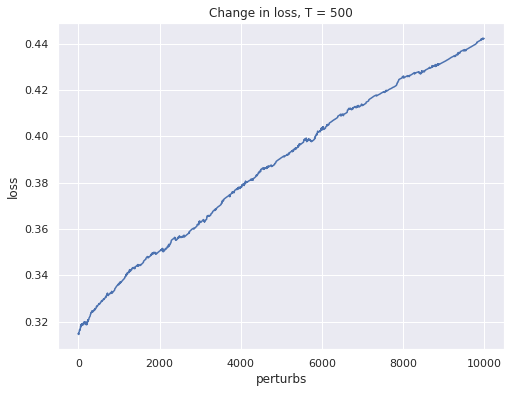

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

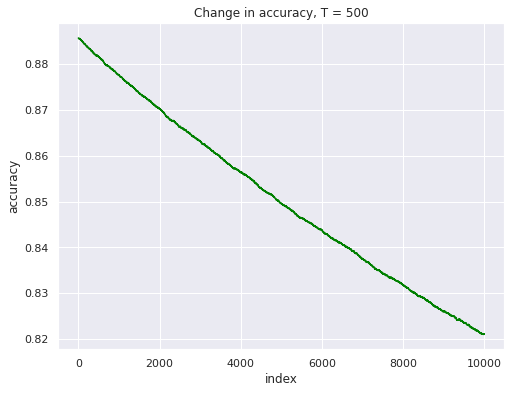

In [28]:
sns.set_theme()

# Loss plot
plt.figure(figsize = (8, 6))
fig = sns.lineplot(data=losses, x="perturbs", y="loss").set_title('Change in loss, T = {}'.format(T)).get_figure()
fig.savefig('plots/losses_' + filename)
plt.show()

# Accuracy plot
plt.figure(figsize = (8, 6))
fig = sns.lineplot(data = perturbations.reset_index(), x = 'index', y = 'accuracy', color = 'green').set_title('Change in accuracy, T = {}'.format(T)).get_figure()
fig.savefig('plots/accuracy_' + filename)
plt.show()

#### **Experimenting with accuracy metric**

In [27]:
# start execution
start_time = time.time()

# GPU settings (set use_gpu = -1 if you want to use CPU)
use_gpu = 0
if use_gpu == -1:
    device = 'cpu'
else:
    device = torch.device('cuda:{}'.format(str(use_gpu)) if torch.cuda.is_available() else 'cpu')

# some hyperparams
lr = 51
T = 500
Delta = 10000 # 5% ~ 10K perturbations
n_factors = 64
save_results = True
manual_gradients = True
retain_graph = True 
create_graph = False

# store loss results in this list and later convert to dataframe 
results = []

# list of perturbations
perturbations = dict()
perturbations['edges'] = []
perturbations['metagrad'] = []
# perturbations['accuracy'] = []
perturbations['accuracy_before'] = []
perturbations['accuracy_after'] = []
perturbations['loss_before'] = []
perturbations['loss_after'] = []

# print hyperparam config
print('-> Learning rate: ', lr)
print('-> T: ', T)
print('-> Delta: {} ({}%)'.format(Delta, round(Delta * 100 / n_samples, 2)))
print('-> Embedding size: ', n_factors)
print('-> Device: ', device)
print('-> Manual gradients: ', manual_gradients)
print('-> Retain graph: ', retain_graph)
print('-> Create graph: ', create_graph)
print('-> Save results: ', save_results)

# load users, items and ratings as tensors
users = torch.tensor(user_list, device = device)
items = torch.tensor(item_list, device = device)
ratings = torch.tensor(rating_list, device = device, requires_grad = True)
perturbs = torch.ones_like(ratings).bool()

# define model and it's parameters
model = CollaborativeFiltering(n_users, n_items, n_factors)
model.to(device)

if manual_gradients == True:
    p1, p2 = model.parameters()
else:
    optimizer = torch.optim.SGD(model.parameters(), lr = 100)

# for each perturbation do the following
for delta in tqdm(range(Delta), desc='-> Perturbations'):

    # makes loss reproducible for each iteration in Delta
    torch.manual_seed(0)

    # reset model paramters 
    for layer in model.children():
        layer.reset_parameters()
    
    # define loss function
    loss_fn = nn.BCELoss(reduction = 'mean')

    model.train()

    # inner loop training process
    if manual_gradients == True:
        for i in range(T):
            y_hat = model(users, items)
            loss = loss_fn(y_hat, ratings)
            results.append([delta, i, loss.item()])

            # compute inner parameter gradients
            p1_grad = torch.autograd.grad(loss, p1, retain_graph=retain_graph, create_graph=create_graph)
            p2_grad = torch.autograd.grad(loss, p2, retain_graph=retain_graph, create_graph=create_graph)

            # update inner parameters
            with torch.no_grad():
                p1_new = p1 - lr * p1_grad[0]
                p2_new = p2 - lr * p2_grad[0]
                p1.copy_(p1_new)
                p2.copy_(p2_new)
    else:
        for i in range(T):
            y_hat = model(users, items)
            loss = loss_fn(y_hat, ratings)
            results.append([delta, i, loss.item()])

            # use torch.optim optimizer to compute gradients
            optimizer.zero_grad()
            loss.backward(retain_graph=retain_graph, create_graph=create_graph)
            optimizer.step()

    # compute and store accuracy of model after T training steps
    with torch.no_grad():
        # compute training accuracy and loss including perturbed edges
        y_hat = model(users, items)
        perturbations['accuracy_before'].append(get_accuracy(y_hat, ratings))
        perturbations['loss_before'].append(loss_fn(y_hat, ratings).item())

        # compute training accuracy and loss excluding perturbed edges
        y_hat_masked = torch.masked_select(y_hat, perturbs)
        ratings_masked = torch.masked_select(ratings, perturbs)
        perturbations['accuracy_after'].append(get_accuracy(y_hat_masked, ratings_masked))
        perturbations['loss_after'].append(loss_fn(y_hat_masked, ratings_masked).item())
    
    # compute meta gradient
    meta_grad = torch.autograd.grad(loss, ratings)[0]

    # select best edge and perform perturbation
    with torch.no_grad():
        mask = ratings.detach().int()
        meta_grad[mask == 1] = 0
        best_edge = meta_grad.argmax().item()
        ratings[best_edge] = 1
        perturbs[best_edge] = False

        # keep track of perturbations and accuracy
        perturbations['edges'].append(best_edge)
        perturbations['metagrad'].append(meta_grad[best_edge].item())

sleep(1)
# compute execution time
exec_time = int(time.time() - start_time)
exec_time = time.strftime("%Hh %Mm %Ss", time.gmtime(exec_time))
print('-> Execution time: {}'.format(exec_time))

# convert results to dataframes for visualisation
results = pd.DataFrame(results, columns = ['perturbs', 'iters', 'loss'])
perturbations = pd.DataFrame(perturbations)
losses = results[results.iters == T - 1][['perturbs', 'loss']].copy()

# save results in CSV format
if save_results:
    filename = 'Delta={}_T={}_LR={}_Factors={}'.format(Delta, T, lr, n_factors) + ('_manual' if manual_gradients else '_auto') + ('_r' if retain_graph else '_c')
    results.to_csv('results/results_' + filename + '.csv')
    perturbations.to_csv('results/perturbations_' + filename + '.csv')
    losses.to_csv('results/losses_' + filename + '.csv')

-> Learning rate:  51
-> T:  500
-> Delta: 10000 (5.0%)
-> Embedding size:  64
-> Device:  cuda:0
-> Manual gradients:  True
-> Retain graph:  True
-> Create graph:  False
-> Save results:  True


-> Perturbations: 100%|██████████| 10000/10000 [2:15:23<00:00,  1.23it/s] 


-> Execution time: 02h 15m 24s


In [28]:
perturbations

,edges,metagrad,accuracy_before,accuracy_after,loss_before,loss_after
0,40063,0.000131,0.887800,0.887800,0.310401,0.310401
1,135373,0.000129,0.887825,0.887829,0.310048,0.309986
2,144575,0.000122,0.887780,0.887789,0.310104,0.309989
3,77684,0.000121,0.887735,0.887748,0.310173,0.309995
4,189021,0.000120,0.887710,0.887728,0.310234,0.310001
...,...,...,...,...,...,...
9995,139377,0.000022,0.823200,0.851314,0.435942,0.372519
9996,24312,0.000023,0.823195,0.851308,0.435956,0.372530
9997,120181,0.000022,0.823200,0.851302,0.435961,0.372532
9998,196402,0.000022,0.823210,0.851312,0.435971,0.372544


#### **More plots**

In [55]:
perturbations_reset = perturbations.reset_index()
perturbations_reset.columns = ['# Perturbations', 'Perturbed edge', 'Meta gradient', 'Accuracy including perturbed edges', 'Accuracy excluding perturbed edges', 'Loss including perturbed edges', 'Loss excluding perturbed edges']
perturbations_reset

,# Perturbations,Perturbed edge,Meta gradient,Accuracy including perturbed edges,Accuracy excluding perturbed edges,Loss including perturbed edges,Loss excluding perturbed edges
0,0,40063,0.000131,0.887800,0.887800,0.310401,0.310401
1,1,135373,0.000129,0.887825,0.887829,0.310048,0.309986
2,2,144575,0.000122,0.887780,0.887789,0.310104,0.309989
3,3,77684,0.000121,0.887735,0.887748,0.310173,0.309995
4,4,189021,0.000120,0.887710,0.887728,0.310234,0.310001
...,...,...,...,...,...,...,...
9995,9995,139377,0.000022,0.823200,0.851314,0.435942,0.372519
9996,9996,24312,0.000023,0.823195,0.851308,0.435956,0.372530
9997,9997,120181,0.000022,0.823200,0.851302,0.435961,0.372532
9998,9998,196402,0.000022,0.823210,0.851312,0.435971,0.372544


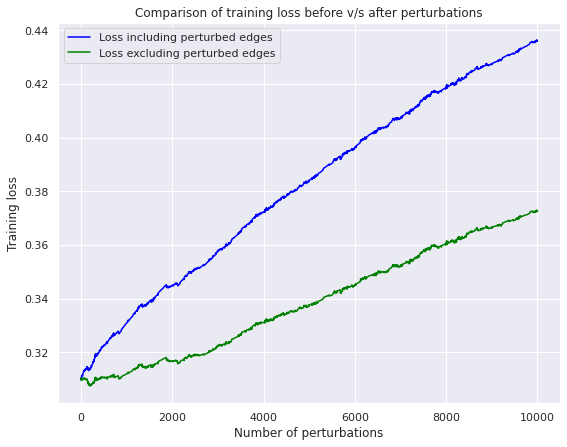

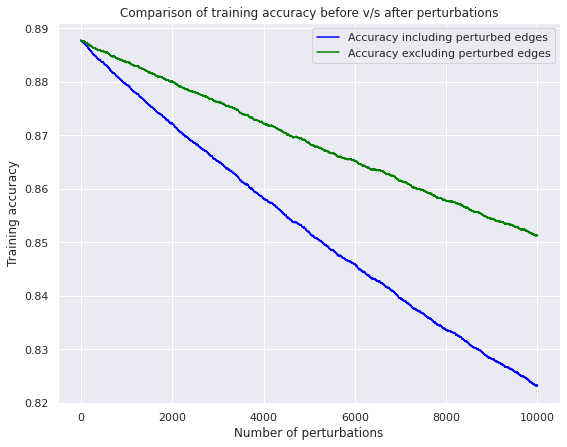

In [61]:
sns.set_theme()
figsize = (9, 7)

# Loss plot

plt.figure(figsize = figsize)
sns.lineplot(data = perturbations_reset, x = '# Perturbations', y = 'Loss including perturbed edges', color = 'blue').set_title('Comparison of training loss before v/s after perturbations')
fig = sns.lineplot(data = perturbations_reset, x = '# Perturbations', y = 'Loss excluding perturbed edges', color = 'green').get_figure()
plt.xlabel('Number of perturbations')
plt.ylabel('Training loss')
plt.legend(labels = ['Loss including perturbed edges', 'Loss excluding perturbed edges'], loc = 'upper left')
fig.savefig('plots/losses_' + filename)
plt.show()

# Accuracy plot
plt.figure(figsize = figsize)
sns.lineplot(data = perturbations_reset, x = '# Perturbations', y = 'Accuracy including perturbed edges', color = 'blue').set_title('Comparison of training accuracy before v/s after perturbations')
fig = sns.lineplot(data = perturbations_reset, x = '# Perturbations', y = 'Accuracy excluding perturbed edges', color = 'green').get_figure()
plt.xlabel('Number of perturbations')
plt.ylabel('Training accuracy')
plt.legend(labels = ['Accuracy including perturbed edges', 'Accuracy excluding perturbed edges'])
fig.savefig('plots/accuracy_' + filename)
plt.show()